##############################################################################
##############################################################################
### **Atelier "Faire du Machine Learning et du Deep Learning sur des Time Series"**
##############################################################################
##############################################################################
<br>
<br>
<br>
<br>
#### **Partie 1 : Machine Learning sur des Times Series univariées** 

Dans cette première partie, nous allons explorer les différentes méthodes  de ML pour les Time Series sur des séries univariées, en mettant en évidence leurs faiblesses et les résolutions proposées par les méthodes suivantes.

<br>
<br>
Méthodes explorées :

1 : ARIMA

2 : SARIMA

3 : TBATS

4 : LSTM

############################################################
<br>
<br>

Objectif de l'Atelier : prédire la consommation éléctrique de la métropole de Brest
<br>
<br>
<br>
<br>










## Section 0 : récupération  et mise en forme des données ##

Nous allons récupérer les informations historiques de consommation électrique en MW de la métropole de Brest. Pour ceci, nous allons faire appel à l'API de l'ODRE et récupérer les informations de consommation pour la zone géographique choisie

In [1]:
import requests
import pandas as pd
import time

def fetch_brest_electricity_data():
    base_url = "https://odre.opendatasoft.com/api/explore/v2.1/catalog/datasets/eco2mix-metropoles-tr/exports/json"
    
    # Paramètres de la requête
    params = {
        "where": "libelle_metropole='Brest Métropole' AND date_heure >= '2020-01-01' AND date_heure <= '2025-12-31'",
        "order_by": "date_heure ASC",
        "timezone": "UTC"
    }
    
    print("Récupération des données pour Brest Métropole (2020-2025)...")
    
    try:
        response = requests.get(base_url, params=params)
        response.raise_for_status()
        
        data = response.json()
        df = pd.DataFrame(data)
        print(df.head())
        
        # On garde ce qui nous faut pour l'atelier : le temps et la consommation électrique associée (puissance en MW)
        df = df[['date_heure', 'consommation']].dropna()
        
        print(f"Chargement Terminé ! {len(df)} lignes récupérées.")
        return df

    except Exception as e:
        print(f" Erreur lors de la récupération : {e}")
        return None


df_conso_brest = fetch_brest_electricity_data()

if df_conso_brest is not None:
    print(df_conso_brest.head())
    # Sauvegarde pour l'atelier
    df_conso_brest.to_csv("conso_brest_2020_2025.csv", index=False)

Récupération des données pour Brest Métropole (2020-2025)...
  code_insee_epci libelle_metropole              nature        date heures  \
0       242900314   Brest Métropole  Données temps réel  2020-01-01  01:00   
1       242900314   Brest Métropole  Données temps réel  2020-01-01  01:15   
2       242900314   Brest Métropole  Données temps réel  2020-01-01  01:30   
3       242900314   Brest Métropole  Données temps réel  2020-01-01  01:45   
4       242900314   Brest Métropole  Données temps réel  2020-01-01  02:00   

                  date_heure  consommation production echanges_physiques  
0  2020-01-01T00:00:00+00:00         106.0       None               None  
1  2020-01-01T00:15:00+00:00         108.0       None               None  
2  2020-01-01T00:30:00+00:00         113.0       None               None  
3  2020-01-01T00:45:00+00:00         121.0       None               None  
4  2020-01-01T01:00:00+00:00         119.0       None               None  
Chargement Terminé !

### traitement initial des séries temporelles ###

Les séries temporelles ont besoin de traitements spécifiques.

Dans le cas présent, nous allons préparer les données en transformant le dataframe en série temporelle, grâce à l'ajout d'un index temporel, très pratique pour manipuler les datas par date.

De plus, nous allons changer la temporalité des données en les rendant journalières, car c'est l'échelle temporelle de notre analyse.

Enfin, nous allons définir les jeux d'entrainement et de test. Dans ce cas, nous allons faire apprendre nos modèles sur la période 2020-2024, et évaluer sur l'année 2025

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt


# indexation temporelle
df_conso_brest['date_heure'] = pd.to_datetime(df_conso_brest['date_heure'], utc=True)
df_conso_brest = df_conso_brest.set_index('date_heure').sort_index()

# changement de temporalité des données
df_daily = df_conso_brest['consommation'].resample('D').mean().interpolate()

# Définition des périodes pour les jeux d'apprentissage
dataset_train = df_daily['2015-01-01':'2024-12-31']
dataset_test = df_daily['2025-01-01':'2025-12-31']


## SECTION 1 : Exploration des données ## 

Dans cette section, nous allons chercher à comprendre la nature des séries temporelles en les décomposant, en analysant leur stationnarité et en recherchant des saisonnalités

### SECTION 1.1 : Visualisation de la décomposition ### 
L'analyse commence par une décomposition classique (STL ou additive) afin d'isoler les composantes fondamentales du signal :

    La Tendance (Trend) : Capture l'évolution à long terme de la consommation électrique.

    La Saisonnalité (Seasonal) : Identifie les variations cycliques périodiques (ici fixée sur 12 unités).
    
    Le Résidu (Residual/Noise) : Représente la composante stochastique ou les anomalies non expliquées par les facteurs déterministes.

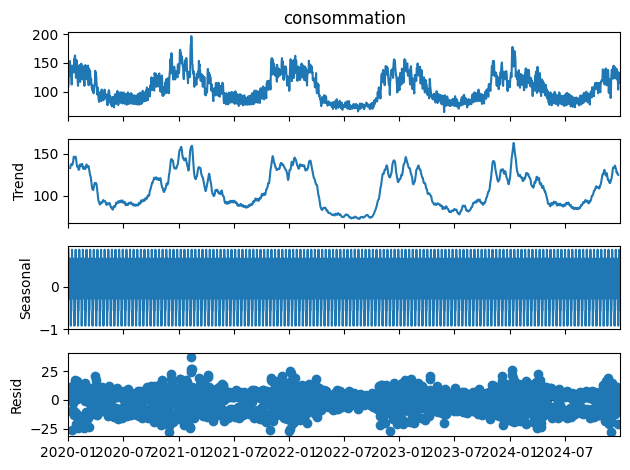

In [3]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(dataset_train, model='additive', period=12)

decomposition.plot()

plt.show()

<br>
<br>
A partir de cette décomposition, cherchez à comprendre qualitativement :
- la saisonnalité de vos données
- les pics observés en hiver
- quelle période de l'année est le plus sujette aux fluctuations aléatoires de consommation

<br>
<br>

### Section 1.2 : Test de stationnarité ## 

La validité des modèles de type Box-Jenkins repose sur la stationnarité de la série (moyenne et variance constantes dans le temps).

    Test de Dickey-Fuller Augmenté (ADF) : Nous testons l'hypothèse nulle (H0​) de présence d'une racine unitaire. Une p-value ≤0.05 indique une série stationnaire.

  

In [6]:
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt


def check_stationarity(series):
    result = adfuller(series.dropna())
    print(f'ADF Statistic: {result[0]:.3f}')
    print(f'p-value: {result[1]:.3e}')
    if result[1] <= 0.05:
        print("=> La série est stationnaire (Rejet de H0)")
    else:
        print("=> La série n'est pas stationnaire (Echec de rejet de H0)")


print("--- Série Brute ---")
check_stationarity(dataset_train)

--- Série Brute ---
ADF Statistic: -2.839
p-value: 5.294e-02
=> La série n'est pas stationnaire (Echec de rejet de H0)


### Section 1.3 : Analyse des saisonnalités ## 

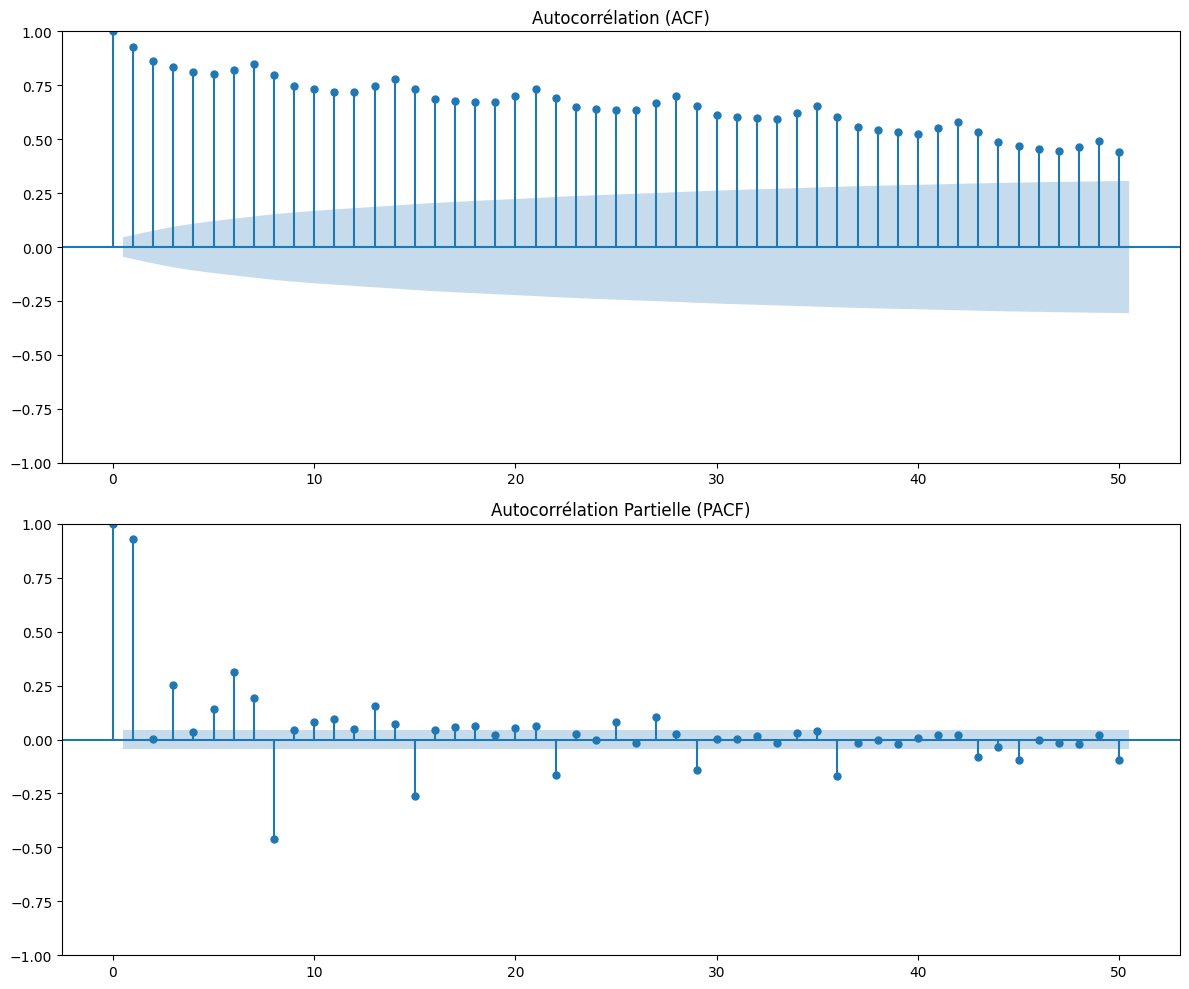

In [5]:
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))

# ACF : Aide à identifier le terme MA (q)
plot_acf(dataset_train.dropna(), lags=50, ax=ax1)
ax1.set_title("Autocorrélation (ACF)")

# PACF : Aide à identifier le terme AR (p)
plot_pacf(dataset_train.dropna(), lags=50, ax=ax2)
ax2.set_title("Autocorrélation Partielle (PACF)")

plt.tight_layout()
plt.show()

<br>
L'interprétation des ACF et des PACF est toujours un moment compliqué. Dans notre cas, nous pouvons dire que les observations des 2 jours précédents sont importants, et qu'il y a une saisonnalité de 7 qui semble apparaitre.

<br>
<br>

Conclusion des analyses : la TS a besoin d'une différentation et de l'annulation d'un lag de 7 jours pour devenir stationnaire. Testons donc cette conclusion


### Section 1.4 : Stationnarisation de la Time Series ## 

--- Série Brute ---
ADF Statistic: -2.839
p-value: 5.294e-02
=> La série n'est pas stationnaire (Echec de rejet de H0)

--- Série après différenciation une différentiation ---
ADF Statistic: -11.806
p-value: 9.079e-22
=> La série est stationnaire (Rejet de H0)


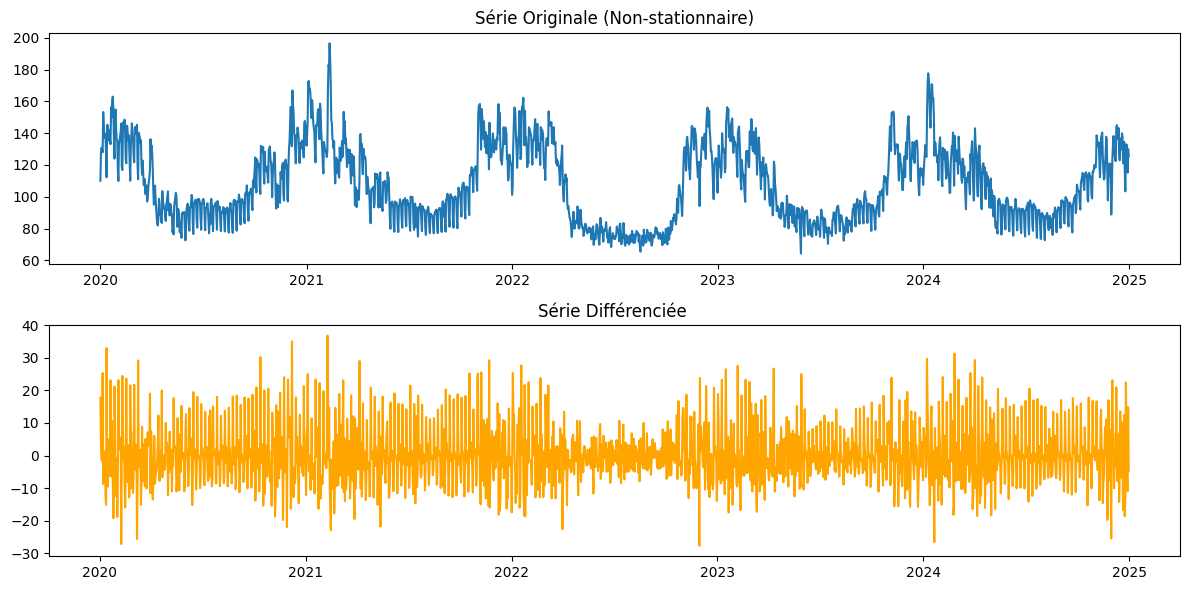

In [11]:
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt


def check_stationarity(series):
    result = adfuller(series.dropna())
    print(f'ADF Statistic: {result[0]:.3f}')
    print(f'p-value: {result[1]:.3e}')
    if result[1] <= 0.05:
        print("=> La série est stationnaire (Rejet de H0)")
    else:
        print("=> La série n'est pas stationnaire (Echec de rejet de H0)")


print("--- Série Brute ---")
check_stationarity(dataset_train)


train_diff = dataset_train.diff().dropna()

print("\n--- Série après différenciation une différentiation ---")
check_stationarity(train_diff)

# 4. Visualisation pédagogique
plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.plot(dataset_train)
plt.title('Série Originale (Non-stationnaire)')

plt.subplot(2, 1, 2)
plt.plot(train_diff, color='orange')
plt.title('Série Différenciée ')
plt.tight_layout()
plt.show()


<br>
<br>
A partir de cette analyse, dressez le tableau qualitatif et quantitatif de votre TS.
<br>
<br>

## SECTION 2  : Création des modèles de ML ##
### SECTION 2.1  : Modélisation autorégressive intégrée (ARIMA) ### 

Nous implémentons un modèle ARIMA comme modèle de référence univariée. Ce modèle combine :

    AR (Auto-regressive) : La dépendance entre une observation et un certain nombre d'observations décalées (lag).

    I (Integrated) : L'utilisation de la différenciation des données brutes pour rendre la série stationnaire.

    MA (Moving Average) : La dépendance entre une observation et l'erreur résiduelle d'un modèle de moyenne mobile appliqué aux observations décalées.


ARIMA demande 3 paramètres :
- p : le nombre de valeurs précedentes à utiliser pour l'AR : d'après l'analyse précedente, il est ici de "Remplissez la valeur"
- d : le nombre de différentiation à effectuer pour que la TS devienne stationnaire, il est ici de "Remplissez la valeur"
- q : le nombre de d'erreurs sur les valeurs précedentes à utiliser pour le MA, , il est ici de "Remplissez la valeur"

In [8]:
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error

model_arima = ARIMA(dataset_train, order=(2, 1, 2))
model_arima_fit = model_arima.fit()

# Prédiction 2025
forecast_arima = model_arima_fit.forecast(steps=len(dataset_test))



c:\Code_ML\Code\Atelier Time Series\.venv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


On affiche ici le graphique de la prédiction par rapport à la réalité. 

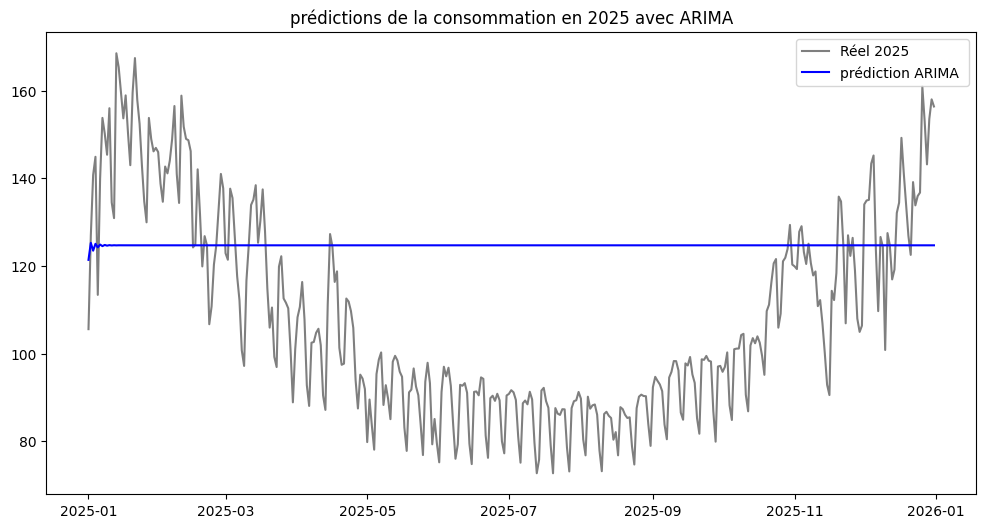

In [9]:
plt.figure(figsize=(12, 6))
plt.plot(dataset_test.index, dataset_test, label='Réel 2025', color='black', alpha=0.5)
plt.plot(dataset_test.index, forecast_arima, label='prédiction ARIMA ', color='blue')

plt.title("prédictions de la consommation en 2025 avec ARIMA")
plt.legend()
plt.show()

<br>
<br>
<br>
Question : Pouvez-vous expliquer pourquoi la méthode ARIMA ne fonctionne pas sur nos données ?
<br>
<br>
<br>

### SECTION 2.2 : Modélisation SARIMA (Saisonal ARIMA) ###

Le modèle SARIMA ​ étend ARIMA en intégrant des paramètres saisonniers explicites. Il permet de modéliser les corrélations à intervalles réguliers, crucial pour les données de consommation présentant par exemple des motifs hebdomadaires distincts (jours ouvrés vs week-end).

In [12]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Définition du modèle
# order=(p, d, q) 
# seasonal_order=(P, D, Q, s) 
#
model_sarima = SARIMAX(dataset_train, 
                order=(1, 1, 1),              
                seasonal_order=(1, 1, 1, 7), 
                enforce_stationarity=False,
                enforce_invertibility=False)

# Entraînement
model_sarima_fit = model_sarima.fit(disp=False)

forecast_sarima = model_sarima_fit.forecast(steps=len(dataset_test))



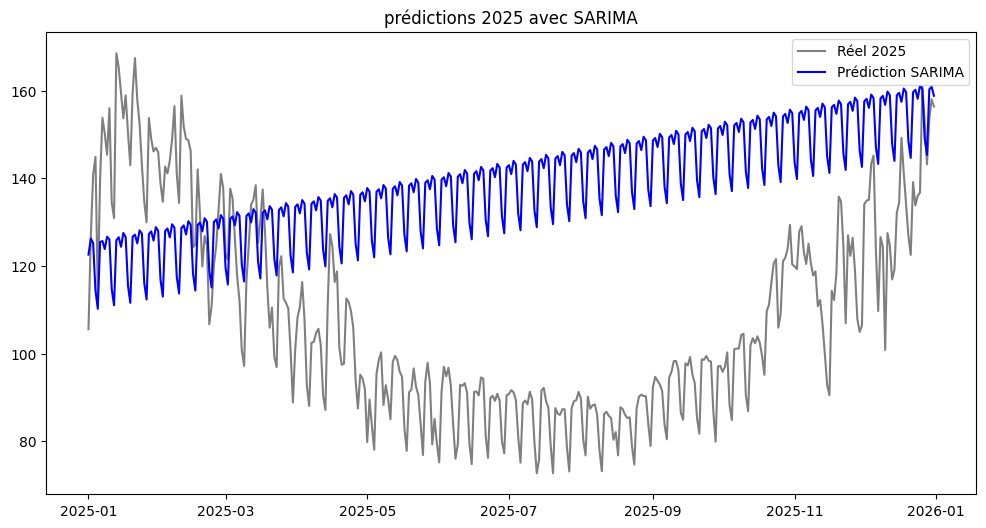

In [ ]:



plt.figure(figsize=(12, 6))
plt.plot(dataset_test.index, dataset_test, label='Réel 2025', color='black', alpha=0.5)
plt.plot(dataset_test.index, forecast_sarima, label='Prédiction SARIMA', color='blue')

plt.title("prédictions 2025 avec SARIMA")
plt.legend()
plt.show()

<br>
<br>
A votre avis, pourquoi SARIMA ne fonctionne pas ? quel élément n'est pas pris en compte ?
<br>
<br>

### SECTION 2.3  Modélisation TBATS (Saisonnalités Multiples) ###

Le modèle TBATS (Trigonometric, Box-Cox, ARMA, Trend, Seasonal) est une approche avancée utilisant des séries de Fourier pour modéliser des saisonnalités multiples et complexes. Ici, il traite simultanément :

    La saisonnalité hebdomadaire (s1​=7).

    La saisonnalité annuelle (s2​=365.25). Il inclut également une transformation de Box-Cox pour gérer l'hétéroscédasticité du signal.

In [13]:

from tbats import TBATS



# 1. Initialisation du modèle
# On définit explicitement les deux cycles : 7 jours et 365.25 jours
estimator = TBATS(seasonal_periods=[7, 365.25])

# 2. Entraînement
model_tbats = estimator.fit(dataset_train)

# 3. Prévision
forecast_tbats = model_tbats.forecast(steps=len(dataset_test))


forecast_index = pd.date_range(start=dataset_train.index[-1], periods=len(dataset_test) + 1, freq='D')[1:]
forecast_series = pd.Series(forecast_tbats, index=forecast_index)

c:\Code_ML\Code\Atelier Time Series\.venv\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Code_ML\Code\Atelier Time Series\.venv\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Code_ML\Code\Atelier Time Series\.venv\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Code_ML\Code\Atelier Time Series\.venv\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Code_ML\Code\Atelier Time Series\.venv\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed 

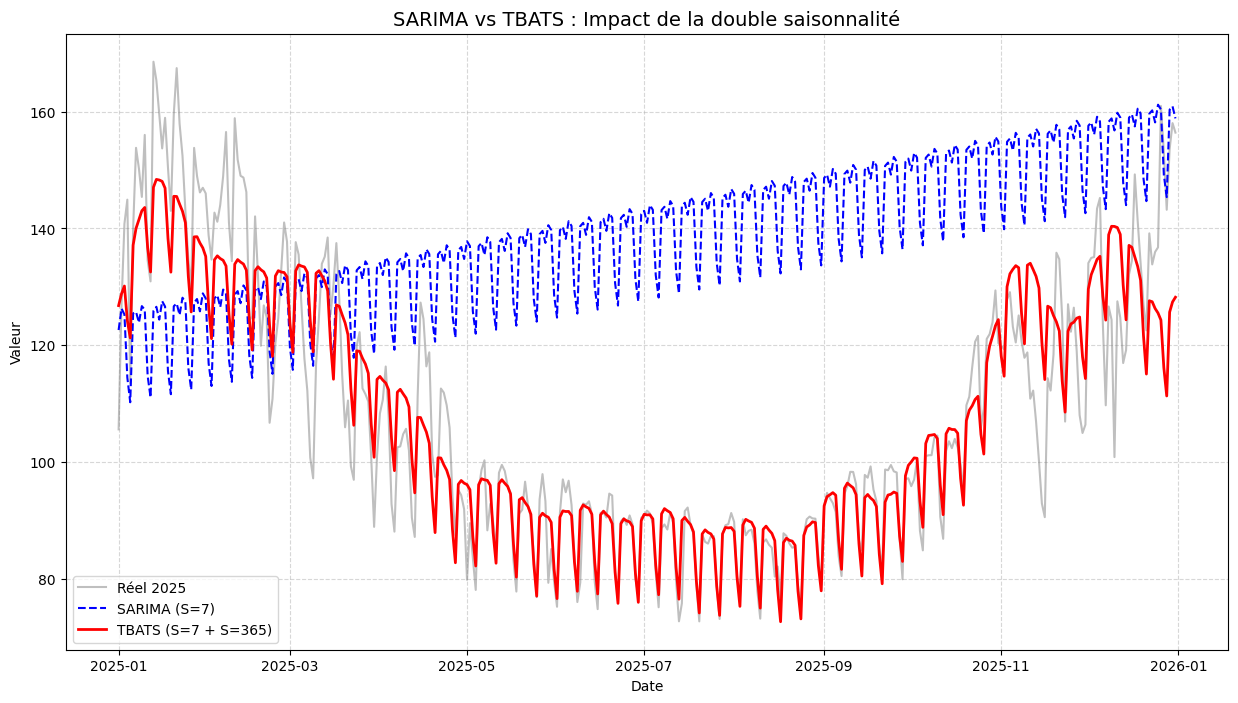

In [ ]:
import matplotlib.pyplot as plt


plt.figure(figsize=(15, 8))


plt.plot(dataset_test.index, dataset_test, color='gray', alpha=0.5, label='Réel 2025')
plt.plot(dataset_test.index, forecast_sarima, color='blue', linestyle='--', label='SARIMA (S=7)')
plt.plot(dataset_test.index, forecast_tbats, color='red', linewidth=2, label='TBATS (S=7 + S=365)')

plt.title('SARIMA vs TBATS : Impact de la double saisonnalité', fontsize=14)
plt.xlabel('Date')
plt.ylabel('Valeur')
plt.legend()
plt.grid(True, which='both', linestyle='--', alpha=0.5)
plt.show()

### SECTION 2.4 : Calcul des erreurs de prédiction des 3 méthodes de ML ###

Nous allons maintenant calculer l'erreur de prédiction de chaque approche.
Nous calculerons l'erreur sur l'année entière, puis l'erreur mensuelle, et enfin l'erreur hebdomadaire

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
import pandas as pd

# 1. Préparation d'un DataFrame de comparaison
results = pd.DataFrame({
    'Réel': dataset_test,
    'SARIMA': forecast_sarima,
    'TBATS': forecast_tbats
}, index=dataset_test.index)

# 2. Fonction de calcul des métriques
def get_metrics(df, actual_col, pred_col):
    mae = mean_absolute_error(df[actual_col], df[pred_col])
    rmse = np.sqrt(mean_squared_error(df[actual_col], df[pred_col]))
    return pd.Series({'MAE': mae, 'RMSE': rmse})

# --- A. Calculs des métriques sur tout le dataset ---
print("--- Métriques Globales ---")
global_sarima = get_metrics(results, 'Réel', 'SARIMA')
global_tbats = get_metrics(results, 'Réel', 'TBATS')
print(f"SARIMA : MAE={global_sarima['MAE']:.2f}, RMSE={global_sarima['RMSE']:.2f}")
print(f"TBATS  : MAE={global_tbats['MAE']:.2f}, RMSE={global_tbats['RMSE']:.2f}")

# --- B. Métriques MENSUELLES ---
# On groupe par mois pour voir où les modèles échouent
monthly_errors = results.groupby(results.index.month).apply(
    lambda x: pd.Series({
        'MAE_SARIMA': mean_absolute_error(x['Réel'], x['SARIMA']),
        'MAE_TBATS': mean_absolute_error(x['Réel'], x['TBATS'])
    })
)

# --- C. Métriques HEBDOMADAIRES ---
weekly_errors = results.groupby(results.index.isocalendar().week).apply(
    lambda x: pd.Series({
        'MAE_SARIMA': mean_absolute_error(x['Réel'], x['SARIMA']),
        'MAE_TBATS': mean_absolute_error(x['Réel'], x['TBATS'])
    })
)

# Affichage des premières lignes mensuelles
print("\n--- Erreurs Mensuelles ---")
print(monthly_errors)
print("\n--- Erreurs hebdomadaires ---")
print(weekly_errors)

--- Métriques Globales ---
SARIMA : MAE=36.99, RMSE=40.82
TBATS  : MAE=6.49, RMSE=9.53

--- Erreurs Mensuelles ---
            MAE_SARIMA  MAE_TBATS
date_heure                       
1            24.233059  10.318680
2            13.953663  10.774974
3            14.162661   9.105125
4            27.691286   8.195856
5            44.720850   3.346333
6            49.520104   1.897019
7            55.213812   1.611404
8            58.453964   1.738194
9            53.715498   2.331727
10           44.093709   3.656095
11           35.234207  11.200080
12           21.246405  14.071044

--- Erreurs hebdomadaires ---
      MAE_SARIMA  MAE_TBATS
week                       
1       9.861035  18.612699
2      22.453350   6.267995
3      34.470692  12.853029
4      25.997038   9.779223
5      21.070577  11.577380
6      19.430111  12.893144
7      18.041477  13.016670
8       6.947901   8.602024
9       6.453171   5.416419
10     12.361390  13.546429
11      7.414135   8.586164
12     17.0284

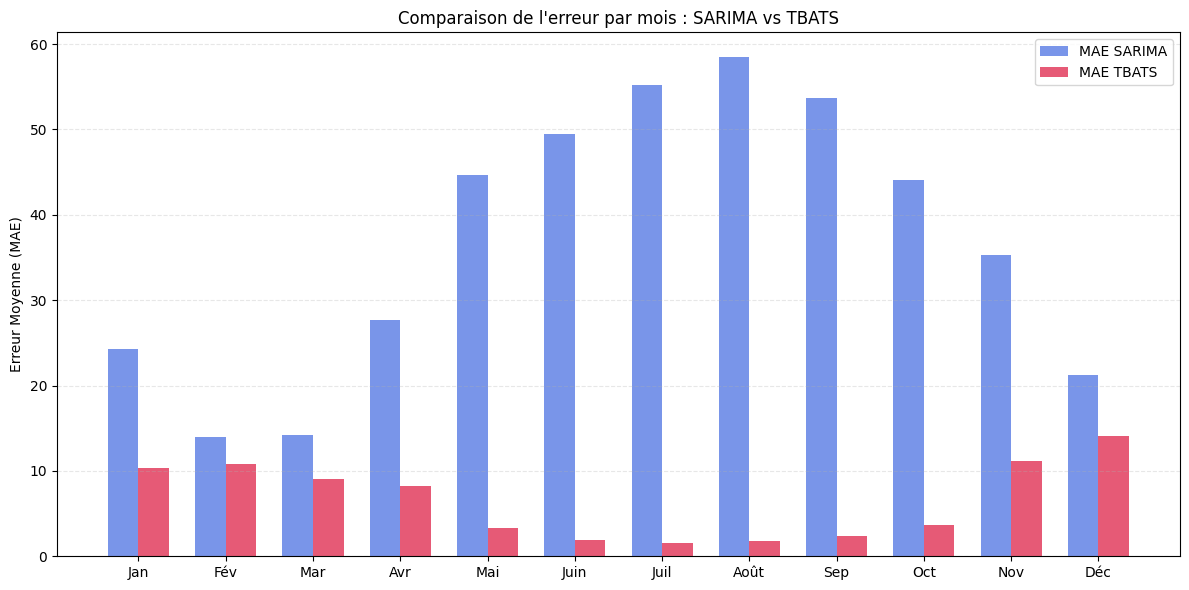

In [ ]:
import matplotlib.pyplot as plt


x = monthly_errors.index
width = 0.35

fig, ax = plt.subplots(figsize=(12, 6))


rects1 = ax.bar(x - width/2, monthly_errors['MAE_SARIMA'], width, 
                label='MAE SARIMA', color='royalblue', alpha=0.7)


rects2 = ax.bar(x + width/2, monthly_errors['MAE_TBATS'], width, 
                label='MAE TBATS', color='crimson', alpha=0.7)


ax.set_ylabel('Erreur Moyenne (MAE)')
ax.set_title('Comparaison de l\'erreur par mois : SARIMA vs TBATS')
ax.set_xticks(x)
ax.set_xticklabels(['Jan', 'Fév', 'Mar', 'Avr', 'Mai', 'Juin', 'Juil', 'Août', 'Sep', 'Oct', 'Nov', 'Déc'])
ax.legend()

plt.grid(axis='y', linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()

### SECTION 2.5 : Modélisation profonde par LSTM

Les modèles de Machine Learning (et particulièrement les réseaux de neurones ou SVR) sont sensibles à l'échelle des données.

    MinMaxScaler / StandardScaler : Transformation des valeurs pour les ramener dans un intervalle réduit (ex: [0,1]).

    Objectif : Éviter que la variable "Consommation" (en centaines de MW) n'écrase par exemple la variable "Température" (en dizaines de degrés).

In [ ]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler

# 1. Normalisation
scaler = MinMaxScaler(feature_range=(0, 1))

train_scaled = scaler.fit_transform(dataset_train.values.reshape(-1, 1))
test_scaled = scaler.transform(dataset_test.values.reshape(-1, 1))



Forme de X_train : (1797, 30, 1)


Nous allons maintenant créer les séquences qui serviront au LSTM

In [ ]:
# 2. Fonction pour créer les séquences
def create_sequences(data, n_steps):
    X, y = [], []
    for i in range(n_steps, len(data)):
        X.append(data[i-n_steps:i, 0])
        y.append(data[i, 0])
    return np.array(X), np.array(y)

#Paramètre critique : quelle longueur d'historicité nous voulons ? Ici ce paramètre est réglé à 30, mais c'est potentiellement beaucoup trop long
n_steps = 30 

X_train, y_train = create_sequences(train_scaled, n_steps)
X_test, y_test = create_sequences(test_scaled, n_steps)

# 4. Reshape pour le LSTM [samples, time steps, features]
# Le LSTM attend une entrée en 3D
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

print(f"Forme de X_train : {X_train.shape}") # (Nb_jours, 30, 1)

Nous allons maintenant entrainer le LSTM

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# 1. Architecture du modèle
model_lstm = Sequential([
    # input_shape = (nombre de jours regardés, nombre de variables)
    LSTM(units=50, activation='tanh', input_shape=(n_steps, 1)),
    
    # Dropout : aide à prévenir le surapprentissage en "désactivant" 20% des neurones aléatoirement
    Dropout(0.2),
    
    # Couche de sortie : 1 neurone pour prédire la valeur du jour suivant
    Dense(units=1)
])

# 2. Compilation

model_lstm.compile(optimizer='adam', loss='mean_squared_error')

early_stop = EarlyStopping(monitor='val_loss', patience=30, restore_best_weights=True)
# 3. Entraînement

history = model_lstm.fit(
    X_train, y_train, 
    epochs=100, 
    batch_size=32, 
    validation_split=0.1,
    callbacks=[early_stop], 
    verbose=1
)

c:\Code_ML\Code\Atelier Time Series\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 0.0241 - val_loss: 0.0054
Epoch 2/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0085 - val_loss: 0.0049
Epoch 3/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0080 - val_loss: 0.0049
Epoch 4/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0078 - val_loss: 0.0053
Epoch 5/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0077 - val_loss: 0.0047
Epoch 6/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0075 - val_loss: 0.0047
Epoch 7/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0073 - val_loss: 0.0047
Epoch 8/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0069 - val_loss: 0.0048
Epoch 9/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0069 - val_loss: 0.0046
Epoch 10/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0069 - val_loss: 0.0049
Epoch 11/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0066 - val_loss: 0.0045
Epoch 12/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0

In [ ]:
# 1. Prédiction sur les données de test
predictions_scaled = model_lstm.predict(X_test)

# 2. Inversion de la normalisation (Denormalization)
predictions_unscaled = scaler.inverse_transform(predictions_scaled)
y_test_unscaled = scaler.inverse_transform(y_test.reshape(-1, 1))

# 3. Création d'une série pandas pour l'affichage
forecast_index_lstm = dataset_test.index[n_steps:]
forecast_lstm = pd.Series(predictions_unscaled.flatten(), index=forecast_index_lstm)

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


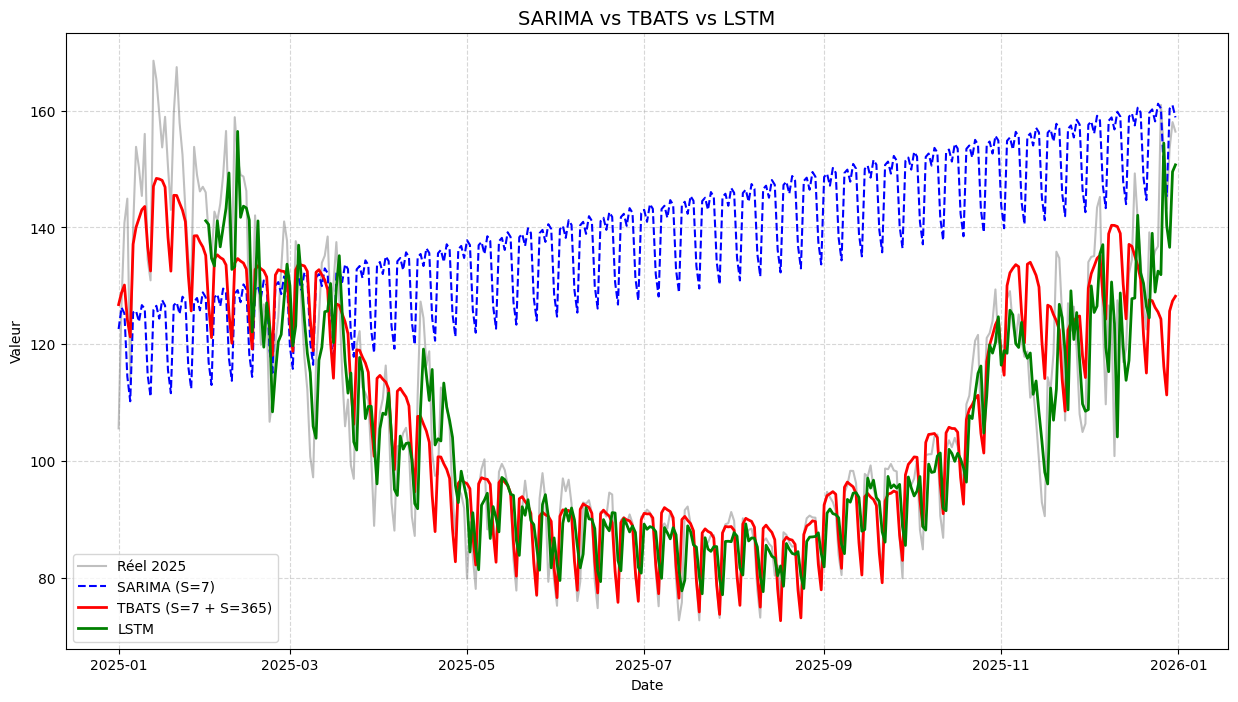

In [ ]:
import matplotlib.pyplot as plt


plt.figure(figsize=(15, 8))


plt.plot(dataset_test.index, dataset_test, color='gray', alpha=0.5, label='Réel 2025')
plt.plot(dataset_test.index, forecast_sarima, color='blue', linestyle='--', label='SARIMA (S=7)')
plt.plot(dataset_test.index, forecast_tbats, color='red', linewidth=2, label='TBATS (S=7 + S=365)')
plt.plot(forecast_lstm.index, forecast_lstm, color='green', linewidth=2, label='LSTM')

plt.title('SARIMA vs TBATS vs LSTM', fontsize=14)
plt.xlabel('Date')
plt.ylabel('Valeur')
plt.legend()
plt.grid(True, which='both', linestyle='--', alpha=0.5)
plt.show()

### SECTION 2.6 : Calcul des erreurs de prédiction de LSTM et comparaison avec les 3 méthodes de ML ###

In [ ]:
mae_lstm = mean_absolute_error(dataset_test[n_steps:], forecast_lstm)
rmse_lstm = np.sqrt(mean_squared_error(dataset_test[n_steps:], forecast_lstm))


# --- A. Métriques GLOBALES (365 jours) ---
print("--- Métriques Globales ---")
global_sarima = get_metrics(results, 'Réel', 'SARIMA')
global_tbats = get_metrics(results, 'Réel', 'TBATS')
print(f"SARIMA : MAE={global_sarima['MAE']:.2f} MW, RMSE={global_sarima['RMSE']:.2f} MW")
print(f"TBATS  : MAE={global_tbats['MAE']:.2f} MW, RMSE={global_tbats['RMSE']:.2f} MW")
print(f"LSTM  : MAE={mae_lstm:.2f} MW, RMSE={rmse_lstm:.2f} MW")

--- Métriques Globales ---
SARIMA : MAE=36.99 MW, RMSE=40.82 MW
TBATS  : MAE=6.49 MW, RMSE=9.53 MW
LSTM  : MAE=6.27 MW, RMSE=8.01 MW
